# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
#Imports
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#built heavily off of https://mljourney.com/multi-label-classification-with-scikit-learn/

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
#other setup
tfds.disable_progress_bar()
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The steam reviews data used initially here is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

In [84]:
# Parse the data
dataset = pd.read_csv('games_reviews_genres_encoded.csv')
dataset['Indie'] = dataset['Indie'].astype(int)
dataset['Utilities'] = dataset['Utilities'].astype(int)
dataset['Sports'] = dataset['Sports'].astype(int)
dataset['Massively_Multiplayer'] = dataset['Massively_Multiplayer'].astype(int)
dataset['Sexual_Content'] = dataset['Sexual_Content'].astype(int)
dataset['Casual'] = dataset['Casual'].astype(int)
dataset['Simulation'] = dataset['Simulation'].astype(int)
dataset['Adventure'] = dataset['Adventure'].astype(int)
dataset['reviews'] = dataset['reviews'].astype(str)
train_dataset = dataset.sample(frac=0.8, random_state=0) # 80% train test split
test_dataset = dataset.drop(train_dataset.index)
print(train_dataset.shape)
print(train_dataset.columns)
train_dataset = train_dataset[['reviews', 'Indie', 'Casual', 'Adventure', 'Sports', 'Massively_Multiplayer']]
test_dataset = test_dataset[['reviews', 'Indie', 'Casual', 'Adventure', 'Sports', 'Massively_Multiplayer']]
train_dataset.head()

(6201, 31)
Index(['Unnamed: 0', 'AppID', 'reviews', 'Genres', 'Tags', 'Price',
       'Estimated.owners', 'Indie', 'Strategy', 'Action', 'Casual',
       'Simulation', 'Sports', 'Adventure', 'Early_Access', 'Utilities', 'RPG',
       'Massively_Multiplayer', 'Free_To_Play', 'Racing', 'Violent', 'Gore',
       'Animation_and_Modeling', 'Design_and_Illustration', 'Video_Production',
       'Nudity', 'Sexual_Content', 'Software_Training', 'Education',
       'Game_Development', 'Audio_Production'],
      dtype='object')


,reviews,Indie,Casual,Adventure,Sports,Massively_Multiplayer
2036,This game is broken.\r\n\r\nIt isn't possible ...,1,0,1,0,0
572,HORRIBLE GAME definetly not worth buying there...,1,0,0,1,0
2570,Surprisingly I enjoy it despite the mixed gene...,0,0,1,0,0
5776,I thought i'd give it a go because its hard to...,1,0,0,1,0
4737,I will admit that I enjoyed The Fox’s Trail a ...,0,0,1,0,0


In [85]:
#check distribution of the categories among training and test datasets
print(np.sum(train_dataset[['Indie', 'Casual', 'Adventure', 'Sports', 'Massively_Multiplayer']], axis=0))
print(np.sum(test_dataset[['Indie', 'Casual', 'Adventure', 'Sports', 'Massively_Multiplayer']], axis=0))

Indie                    4439
Casual                   2548
Adventure                2411
Sports                    302
Massively_Multiplayer     107
dtype: int64
Indie                    1113
Casual                    629
Adventure                 576
Sports                     76
Massively_Multiplayer      35
dtype: int64


In [86]:
#convert to tfds
tf_train_dataset = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
#tf_train_dataset = tf.convert_to_tensor(train_dataset)
tf_test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_dataset))
tf_train_dataset.element_spec

{'reviews': TensorSpec(shape=(), dtype=tf.string, name=None),
 'Indie': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Casual': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Adventure': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Sports': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'Massively_Multiplayer': TensorSpec(shape=(), dtype=tf.int64, name=None)}

In [87]:
#print element from data, one game's reviews and its associated class labels
for elem in tf_train_dataset.take(1):
  print('Reviews: ', elem['reviews'].numpy())
  print('Indie: ', elem['Indie'].numpy())
  print('Casual: ', elem['Casual'].numpy())
  print('Adventure: ', elem['Adventure'].numpy())
  print('Sports: ', elem['Sports'].numpy())
  print('Massively_Multiplayer: ', elem['Massively_Multiplayer'].numpy())

Reviews:  b'This game is broken.\r\n\r\nIt isn\'t possible to open chests or use your "special ability," and the level doesn\'t have an exit or an end boss.'
Indie:  1
Casual:  0
Adventure:  1
Sports:  0
Massively_Multiplayer:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [88]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [89]:
tf_train_dataset = tf_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test_dataset = tf_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [90]:
#print sample (1 batch) from data, three games reviews and their associated class labels
for element in tf_train_dataset.take(1):
  print('reviews: ', element['reviews'].numpy()[:3])
  print()
  print('Indie: ', element['Indie'].numpy()[:3])
  print('Casual:', element['Casual'].numpy()[:3])
  print('Adventure: ', element['Adventure'].numpy()[:3])
  print('Sports: ', element['Sports'].numpy()[:3])
  print('Massively_Multiplayer: ', element['Massively_Multiplayer'].numpy()[:3])

reviews:  [b'Dead software\r\n\r\ni mean, it DOES work, but the requirement for a specific, outdated unity version is already very bad.\r\nthe fact that it does require unity and doesn\'t come with an integrated- or support of an easier/more model generating software(s), makes it very bad for everyone that isn\'t a professional "nerd". \r\n\r\nvery weak performace, even when huge potential.\r\ni loved and still LOVE wallpaper engine for its huge amount of features and easy use without real knowledge like coding or modelling - at least on 2D wallpapers: All you have to do is invest some time and you can get pretty results.\r\nbut THIS software here, just underperforms and requires alot of skills when you want to create your own custom project.\r\n\r\nIf you have unity skills AND want to go through the trouble with the old unity version OR are easy to satisfy with the ~20 avaible models, at the moment, go ahead and buy it.\r\notherwise, go buy "Wallpaper Engine" instead in case you haven

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

There is room for improvement here, vectorization with certain dictionaries or parameters may affect model accuracy.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [91]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_train_dataset.map(lambda x: x['reviews']))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

Note: Should filter for significant tokens. 'a' and 'the' and 'in' and so on are not helpful.

In [92]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'of', 'i', 'is',
       'it', 'you', 'this', 'in', 'that', 'for', 'but', 'with', 'are',
       'on'], dtype='<U31')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [93]:
encoded_example = encoder(element['reviews'])[:3].numpy()
encoded_example

array([[ 560, 1025,    8, ...,    0,    0,    0],
       [  20,    5,   37, ...,    0,    0,    0],
       [  12,    9,  659, ...,    0,    0,    0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [94]:
for n in range(3):
  print("Original: ", element['reviews'][n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Dead software\r\n\r\ni mean, it DOES work, but the requirement for a specific, outdated unity version is already very bad.\r\nthe fact that it does require unity and doesn\'t come with an integrated- or support of an easier/more model generating software(s), makes it very bad for everyone that isn\'t a professional "nerd". \r\n\r\nvery weak performace, even when huge potential.\r\ni loved and still LOVE wallpaper engine for its huge amount of features and easy use without real knowledge like coding or modelling - at least on 2D wallpapers: All you have to do is invest some time and you can get pretty results.\r\nbut THIS software here, just underperforms and requires alot of skills when you want to create your own custom project.\r\n\r\nIf you have unity skills AND want to go through the trouble with the old unity version OR are easy to satisfy with the ~20 avaible models, at the moment, go ahead and buy it.\r\notherwise, go buy "Wallpaper Engine" instead in case you haven

## Create the model

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

4. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [95]:
single_prediction_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=False), #changed from True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') #changed from softmax
])

# Summary of the model
single_prediction_model.summary()

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Compile the model
single_prediction_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=METRICS
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [97]:
print([layer.supports_masking for layer in single_prediction_model.layers])

[False, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [99]:
# predict on a sample text without padding.

sample_text = "The game was cool. The animation and the graphics were out of this world. I would recommend this game."
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)

# Exapanded layers to see output
layer2 = tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
layer2_output = layer2(encoded_example)

layer3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
layer3_output = layer3(layer2_output)

layer4 = tf.keras.layers.Dense(64, activation='relu')
layer4_output = layer4(layer3_output)

layer5 = tf.keras.layers.Dense(1)
layer5_output = layer5(layer4_output)

predictions = single_prediction_model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.4940121]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [100]:
# predict on a sample text with padding

padding = "the " * 2000
encoded_padding = tf.expand_dims(encoder(padding), axis=0)

predictions = single_prediction_model.predict(encoded_example)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
[0.4940121]


## Train the model

We train models on each category indiviudally, to demonstrate the feasiblity of predicting genre correctly for each category.

In [101]:
encoded_Indie_train = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie']], axis=-1)))
encoded_Indie_test = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie']], axis=-1)))
#see examble of what data looks like now
for x, y in encoded_Indie_train.take(1):
  print(x[0])
  print(y[0])

tf.Tensor([1695  436   25 ...    0    0    0], shape=(16460,), dtype=int64)
tf.Tensor([1], shape=(1,), dtype=int64)


In [ ]:
single_prediction_model.fit(encoded_Indie_train, epochs=10,
                    validation_data=encoded_Indie_test,
                    validation_steps=30)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 818ms/step - Brier score: 0.2161 - accuracy: 0.6986 - auc: 0.4929 - cross entropy: 0.6235 - fn: 48.9898 - fp: 867.9490 - loss: 0.6235 - prc: 0.7172 - precision: 0.7168 - recall: 0.9454 - tn: 17.9796 - tp: 2232.2856 - val_Brier score: 0.2031 - val_accuracy: 0.7181 - val_auc: 0.5722 - val_cross entropy: 0.5964 - val_fn: 0.0000e+00 - val_fp: 437.0000 - val_loss: 0.5964 - val_prc: 0.7671 - val_precision: 0.7181 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 1113.0000
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 818ms/step - Brier score: 0.2016 - accuracy: 0.7141 - auc: 0.5902 - cross entropy: 0.5924 - fn: 0.0000e+00 - fp: 901.7755 - loss: 0.5924 - prc: 0.7690 - precision: 0.7140 - recall: 1.0000 - tn: 0.4184 - tp: 2265.0103 - val_Brier score: 0.1988 - val_accuracy: 0.7181 - val_auc: 0.5860 - val_cross entropy: 0.5859 - val_fn: 1.0000 - val_fp: 436.0000 - val_loss: 0.5859 - val_prc: 0.7732 - val_precision: 0.7183 - val_recall: 0.9991 - val_tn: 1.0000 - val_tp: 1112.0000
Epoch 3/10
31/97 ━━━━━━━━━━━━━━━━━━━━ 50s 768ms/step - Brier score: 0.1744 - accuracy: 0.7317 - auc: 0.7593 - cross entropy: 0.5245 - fn: 2.4516 - fp: 273.0645 - loss: 0.5245 - prc: 0.8803 - precision: 0.7305 - recall: 0.9980 - tn: 10.7097 - tp: 737.7742

As can be seen, the model predicts the class with high accuracy on both the training and validation datasets.

Now we try to build a model for predicting all the categories at once. This is a multi-layer classification problem, introducing additional complexity because the genre classes are not mutually exclusive.

We reconstruct the model to use sigmoid activation in the final layer, and an output value for each class. We also introduce an additional LSTIM layer to deal with the increased complexity.

Because we are now dealing with multiple classes who are unequally represented in the dataset, we must also calculate class distribution to inform our loss function.

In [ ]:
multilabel_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True), #changed from True
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='sigmoid') #changed from softmax
])

# Summary of the model
multilabel_model.summary()

#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      tf.keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      tf.keras.metrics.MeanSquaredError(name='Brier score'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Compile the model
multilabel_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=METRICS
)

In [74]:
encoded_train_dataset = tf_train_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))
encoded_test_dataset = tf_test_dataset.map(lambda x: (encoder(x['reviews']), tf.stack([x['Indie'], x['Casual'], x['Adventure']], axis=-1)))

# Calculate genre distribution
class_counts = np.sum(train_dataset[['Indie', 'Casual', 'Adventure']], axis=0)
print(class_counts)
total_samples = len(train_dataset[['Indie', 'Casual', 'Adventure']])
print(total_samples) #because the classes are not exclusive, this is not the two class counts added together
class_weights = total_samples / (class_counts * len(class_counts))
class_weights = class_weights.tolist()
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

tf.Tensor([ 344 2137 1189 ...    0    0    0], shape=(14038,), dtype=int64)
tf.Tensor([1 0 0], shape=(3,), dtype=int64)
Indie        4439
Casual       2548
Adventure    2411
dtype: int64
6201


In [ ]:
#split data back out for (used for some models)
x_train = []
x_test = []
y_train = []
y_test = []
for x, y in encoded_train_dataset.take(-1):
  x_train.append(x)
  y_train.append(y)
for x, y in encoded_test_dataset.take(-1):
  x_test.append(x)
  y_test.append(y)
#print(x_train[0])
#print(y_train[0])

In [79]:
history = model.fit(encoded_train_dataset, epochs=10,
                    validation_data=encoded_test_dataset,
                    validation_steps=30,
                    class_weight=class_weights_dict)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 812ms/step - Brier score: 0.2399 - accuracy: 0.6147 - auc: 0.6288 - cross entropy: 0.6728 - fn: 2553.6226 - fp: 999.4388 - loss: 0.3571 - prc: 0.6293 - precision: 0.6789 - recall: 0.4429 - tn: 3703.5613 - tp: 2244.9897 - val_Brier score: 0.2290 - val_accuracy: 0.6469 - val_auc: 0.6614 - val_cross entropy: 0.6505 - val_fn: 1205.0000 - val_fp: 437.0000 - val_loss: 0.6505 - val_prc: 0.6686 - val_precision: 0.7181 - val_recall: 0.4802 - val_tn: 1895.0000 - val_tp: 1113.0000
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


97/97 ━━━━━━━━━━━━━━━━━━━━ 77s 787ms/step - Brier score: 0.2324 - accuracy: 0.6380 - auc: 0.6458 - cross entropy: 0.6573 - fn: 2512.8572 - fp: 928.6633 - loss: 0.3496 - prc: 0.6492 - precision: 0.7128 - recall: 0.4760 - tn: 3785.6836 - tp: 2274.4082 - val_Brier score: 0.2263 - val_accuracy: 0.6469 - val_auc: 0.6626 - val_cross entropy: 0.6446 - val_fn: 1205.0000 - val_fp: 437.0000 - val_loss: 0.6446 - val_prc: 0.6760 - val_precision: 0.7181 - val_recall: 0.4802 - val_tn: 1895.0000 - val_tp: 1113.0000
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 87s 841ms/step - Brier score: 0.2246 - accuracy: 0.6427 - auc: 0.6771 - cross entropy: 0.6402 - fn: 2518.8469 - fp: 887.3674 - loss: 0.3396 - prc: 0.7010 - precision: 0.7277 - recall: 0.4790 - tn: 3783.7144 - tp: 2311.6836 - val_Brier score: 0.2275 - val_accuracy: 0.6312 - val_auc: 0.6588 - val_cross entropy: 0.6465 - val_fn: 1290.0000 - val_fp: 425.0000 - val_loss: 0.6465 - val_prc: 0.6700 - val_precision: 0.7075 - val_recall: 0.4435 - val_tn: 1907.00

In [80]:
#https://www.tensorflow.org/tutorials/keras/save_and_load
model.save_weights('./multilabel-model.weights.h5')

In [ ]:
model.evaluate(encoded_test_dataset)

25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - Brier score: 0.2676 - accuracy: 0.6347 - auc: 0.6751 - cross entropy: 0.9144 - fn: 461.9615 - fp: 494.7692 - loss: 0.9144 - prc: 0.6689 - precision: 0.6301 - recall: 0.6432 - tn: 799.8077 - tp: 816.5385


[0.9545629024505615,
 0.9545629024505615,
 0.27757397294044495,
 1460.0,
 910.0,
 1422.0,
 858.0,
 0.6197850108146667,
 0.6160337328910828,
 0.6298533082008362,
 0.6573556661605835,
 0.6503210067749023]

In [81]:
#Gemini generated chunk

# Retrieve the original unbatched test reviews and labels directly from the `test_dataset` DataFrame
# This ensures perfect alignment between reviews and their true labels.
test_reviews_original = test_dataset['reviews'].values
y_true = test_dataset[['Indie', 'Casual', 'Adventure']].values # Ensure correct order and type

# Encode the reviews for prediction using the pre-trained encoder
encoded_test_reviews_for_prediction = encoder(test_reviews_original)

# Create a tf.data.Dataset from the encoded reviews for batching during prediction
prediction_dataset = tf.data.Dataset.from_tensor_slices(encoded_test_reviews_for_prediction).batch(BATCH_SIZE)

# Get predictions from the model
y_pred_probs = model.predict(prediction_dataset)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred_binary = (y_pred_probs > 0.5).astype(int)

misclassified_reviews_list = []
misclassified_true_labels_list = []
misclassified_predicted_labels_list = []
misclassified_predicted_probabilities_list=[]

# Iterate through each sample to find misclassified ones
# A sample is misclassified if its predicted binary labels do not exactly match the true binary labels
for i in range(len(y_true)): # Loop up to the length of true labels
    if not np.array_equal(y_pred_binary[i], y_true[i]):
        misclassified_reviews_list.append(test_reviews_original[i])
        misclassified_true_labels_list.append(y_true[i])
        misclassified_predicted_probabilities_list.append(y_pred_probs[i])
        misclassified_predicted_labels_list.append(y_pred_binary[i])


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 538ms/step


In [82]:
print(f"\nNumber of misclassified samples: {len(misclassified_reviews_list)}")
print(f"\nTotal number of samples: {len(y_true)}")
print("\nFirst 100 Misclassified Predictions:\n")
for i in range(min(100, len(misclassified_reviews_list))):
    print(f"True Labels (Indie, Casual, Adventure): {misclassified_true_labels_list[i]}")
    print(f"Predicted Probabilities (Indie, Casual, Adventure): {misclassified_predicted_probabilities_list[i]}")
    print(f"Predicted Labels (Indie, Casual, Adventure): {misclassified_predicted_labels_list[i]}")


Number of misclassified samples: 1224

Total number of samples: 1550

First 100 Misclassified Predictions:

True Labels (Indie, Casual, Adventure): [1 0 0]
Predicted Probabilities (Indie, Casual, Adventure): [0.97272116 0.4345957  0.6592217 ]
Predicted Labels (Indie, Casual, Adventure): [1 0 1]
True Labels (Indie, Casual, Adventure): [1 0 0]
Predicted Probabilities (Indie, Casual, Adventure): [0.00303748 0.4440973  0.7286453 ]
Predicted Labels (Indie, Casual, Adventure): [0 0 1]
True Labels (Indie, Casual, Adventure): [1 1 0]
Predicted Probabilities (Indie, Casual, Adventure): [0.03739871 0.561986   0.1251058 ]
Predicted Labels (Indie, Casual, Adventure): [0 1 0]
True Labels (Indie, Casual, Adventure): [1 0 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.03072242 0.55746686 0.22110903]
Predicted Labels (Indie, Casual, Adventure): [0 1 0]
True Labels (Indie, Casual, Adventure): [1 1 1]
Predicted Probabilities (Indie, Casual, Adventure): [0.64290345 0.65224105 0.08406249]
Pred

(0.0, 1.048261681944132)

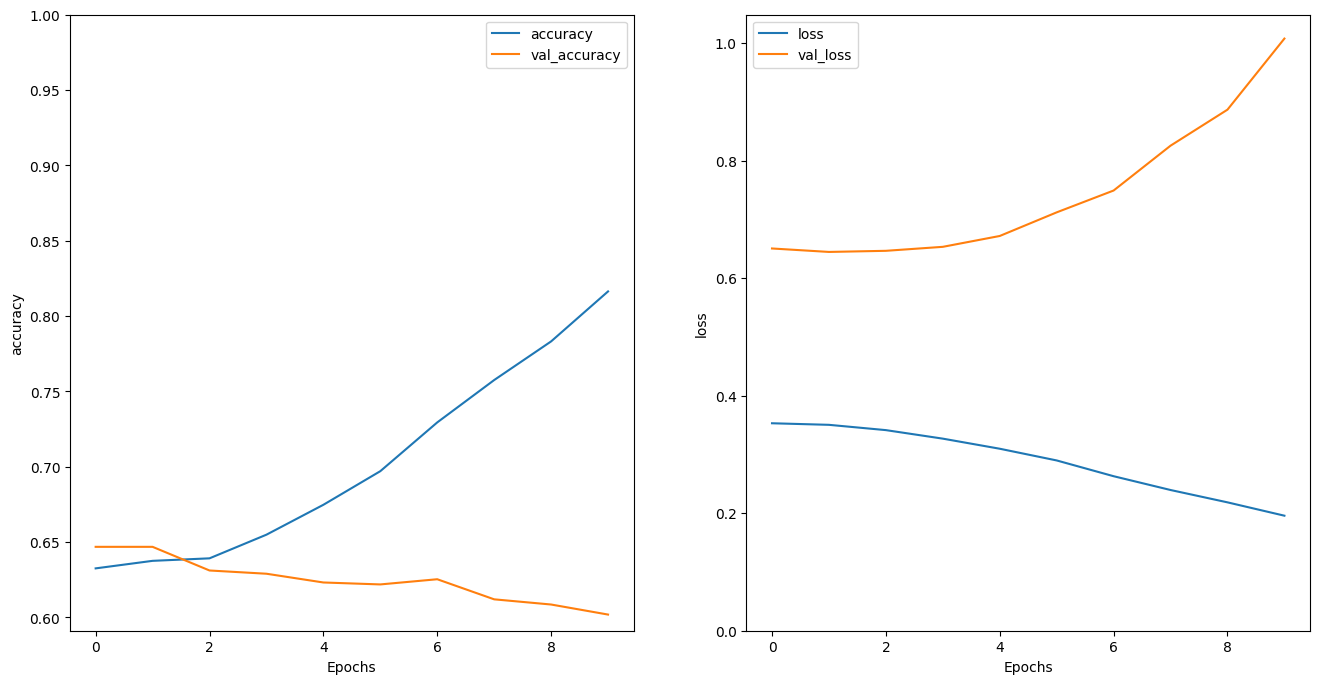

In [83]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('This was an indie game. It was not an adventure game. It was not a casual game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was cool. I like the way it doesnt take too much energy. '
                'Shoutout to the small team of devs that made it possible. I would recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

sample_text = ('This game was not cool. The animation and the graphics '
               'looked expensive but the gameplay was soulless. Disgrace of a AAA game.'
               'I would not recommend this game.')
encoded_example = encoder(sample_text)

# The Embedding layer expects a batch dimension, even for a single sample
encoded_example = tf.expand_dims(encoded_example, axis=0)
predictions = model.predict(encoded_example)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
[[0.6455133  0.20965926 0.8006546 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.93354255 0.04071651 0.9741969 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.07430513 0.13745649 0.9803309 ]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True, use_cudnn=False)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, use_cudnn=False)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

NameError: name 'tf' is not defined




Another way of going about this same process, noted here in case we have to resort to it.

In [ ]:
# Train the https://keras.io/examples/nlp/multi_label_classification/  model
# Binary Relevance with Logistic Regression
binary_relevance = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, random_state=42)
)
binary_relevance.fit(x_train, y_train)

In [ ]:
# Make predictions
y_pred_br = binary_relevance.predict(x_test)
y_pred_proba_br = binary_relevance.predict_proba(x_test)

# Evaluate performance
hamming_loss_br = hamming_loss(y_test, y_pred_br)
jaccard_score_br = jaccard_score(y_test, y_pred_br, average='samples')

print(f"Binary Relevance Results:")
print(f"Hamming Loss: {hamming_loss_br:.4f}")
print(f"Jaccard Score: {jaccard_score_br:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c